# Applying Deep Batch Active Learning to your own learning task

In this notebook, we show how our implemented batch mode deep active learning (BMDAL) methods can be applied to a custom NN. We will first change the working directory from the examples subfolder to the main folder, which is required for the imports to work correctly.

In [1]:
import os
os.chdir('..')   # change directory inside the notebook to the main directory

## Example with artificial data and custom model

We first generate some artificial 2-D training data, which will be plotted below.

In [2]:
import torch
import torch.nn as nn

n_train = 100
n_pool = 2000
torch.manual_seed(1234)
x = torch.randn(n_train+n_pool, 3)
theta = 3*(x[:, 1] + 0.1 * x[:, 0])
x = (0.2 * x[:, 2] + x[:, 1] + 2)[:, None] * torch.stack([torch.sin(theta), torch.cos(theta)], dim=1)
y = torch.exp(x[:, 0])
y = y[:, None]

x_train = x[:n_train]
y_train = y[:n_train]
x_pool = x[n_train:]
y_pool = y[n_train:]

Note that for the labels, we have used the deterministic function $y = e^{x_1}$. In order to learn this function, it would be better to have more training points on the right of the domain. We can visualize the pool set (in gray) and the train set (in black) without the labels as follows:

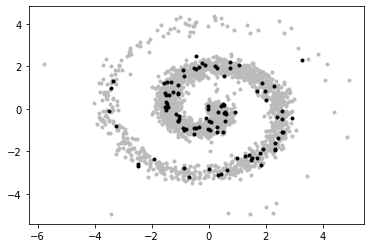

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_pool[:, 0].numpy(), x_pool[:, 1].numpy(), '.', color='#BBBBBB')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), '.', color='k')
plt.show()

Next, we train a NN on the given training data. For this, we use a simple three-layer NN using the standard layers from PyTorch. Since we only have 100 training points, we use all of the data in each step. We optimize the NN using Adam for 256 epochs with fixed learning rate. These hyperparameters are only an example, you may use other values.

In [4]:
custom_model = nn.Sequential(nn.Linear(2, 100), nn.SiLU(), nn.Linear(100, 100), nn.SiLU(), nn.Linear(100, 1))
opt = torch.optim.Adam(custom_model.parameters(), lr=2e-2)
for epoch in range(256):
    y_pred = custom_model(x_train)
    loss = ((y_pred - y_train)**2).mean()
    train_rmse = loss.sqrt().item()
    pool_rmse = ((custom_model(x_pool) - y_pool)**2).mean().sqrt().item()
    print(f'train RMSE: {train_rmse:5.3f}, pool RMSE: {pool_rmse:5.3f}')
    loss.backward()
    opt.step()
    opt.zero_grad()

train RMSE: 5.334, pool RMSE: 7.043
train RMSE: 4.116, pool RMSE: 6.060
train RMSE: 2.640, pool RMSE: 4.933
train RMSE: 2.833, pool RMSE: 4.774
train RMSE: 2.589, pool RMSE: 4.797
train RMSE: 1.809, pool RMSE: 4.461
train RMSE: 1.725, pool RMSE: 4.376
train RMSE: 1.956, pool RMSE: 4.430
train RMSE: 1.917, pool RMSE: 4.374
train RMSE: 1.600, pool RMSE: 4.187
train RMSE: 1.261, pool RMSE: 3.989
train RMSE: 1.320, pool RMSE: 3.916
train RMSE: 1.594, pool RMSE: 3.940
train RMSE: 1.584, pool RMSE: 3.909
train RMSE: 1.325, pool RMSE: 3.840
train RMSE: 1.161, pool RMSE: 3.844
train RMSE: 1.234, pool RMSE: 3.919
train RMSE: 1.332, pool RMSE: 3.976
train RMSE: 1.303, pool RMSE: 3.960
train RMSE: 1.151, pool RMSE: 3.882
train RMSE: 0.988, pool RMSE: 3.794
train RMSE: 0.970, pool RMSE: 3.752
train RMSE: 1.069, pool RMSE: 3.755
train RMSE: 1.098, pool RMSE: 3.754
train RMSE: 0.993, pool RMSE: 3.728
train RMSE: 0.870, pool RMSE: 3.713
train RMSE: 0.868, pool RMSE: 3.737
train RMSE: 0.937, pool RMSE

Next, we want to select 50 new points to label using Deep Batch Active Learning. For this, we wrap our training and pool inputs in the `TensorFeatureData` class and call the method `bmdal.algorithms.select_batch()` method with the batch size (50), our trained model, training and pool data as well as our desired configuration of selection method, mode (`sel_with_train`), base kernel and kernel transformations. Here, we use the LCMD-TP method proposed in our paper. For an extensive overview over the available options, we refer to the docstring in the code for `bmdal.algorithms.select_batch()`. Finally, we plot the selected samples from the pool set.

Note: If your training / pool data is so large that it does not fit on the device (CPU/GPU), you may need to write a custom `FeatureData` subclass, where the `get_tensor_impl_()` method acts as a data loader. Please contact the library author in this case.

The function `select_batch()` supports the computation of gradient features for layers of type `nn.Linear` by default. In order to support gradients for other types of layers, there are two options:
- The first option is that the other layers inherit from `bmdal.layer_features.LayerGradientComputation` and implement the corresponding methods. For example, the class `bmdal.layer_features.LinearLayer` does this. In contrast to `nn.Linear`, it supports the factors $\sigma_w/\sqrt{d_l}$ and $\sigma_b$ from the paper, and it is used in our benchmarking code.
- The second option is that a matching of the other layer types to corresponding subclasses of `bmdal.layer_features.LayerGradientComputation` is provided via the `layer_grad_dict` argument of `select_batch()`. For more details, we refer to the documentation of `select_batch()`.

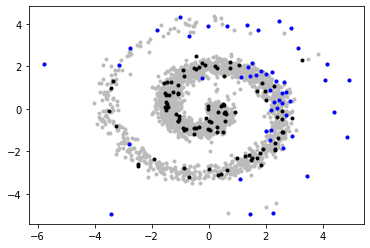

In [5]:
from bmdal.feature_data import TensorFeatureData
from bmdal.algorithms import select_batch

train_data = TensorFeatureData(x_train)
pool_data = TensorFeatureData(x_pool)
new_idxs, _ = select_batch(batch_size=50, models=[custom_model], 
                           data={'train': train_data, 'pool': pool_data}, y_train=y_train,
                           selection_method='lcmd', sel_with_train=True,
                           base_kernel='grad', kernel_transforms=[('rp', [512])])

plt.plot(x_pool[:, 0].numpy(), x_pool[:, 1].numpy(), '.', color='#BBBBBB')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), '.', color='k')
plt.plot(x_pool[new_idxs, 0].numpy(), x_pool[new_idxs, 1].numpy(), '.', color='b')
plt.show()

We can observe that the BMDAL method selected more pool samples from the right of the domain. This is desirable since the target function is $y = e^{x_1}$, which is steeper at the right of the domain. This behavior would not arise from a network-independent base kernel like 'linear', 'nngp' or 'laplace'.

## Example using our benchmark data and training code

In the following, we will give a different example, utilizing a data set from our benchmark and our functions for creating and fitting fully-connected NN models. The code is adapted from `ModelTrainer.__call__()` in `train.py`. First, we need to choose a data set. We choose the `road_network` data set since it contains 2D inputs representing locations in north Denmark, which can be nicely visualized. We choose an initial training set size of `n_train=256`. The argument `al_batch_sizes` is not relevant to us here since we will choose the batch size later manually. We then create a random split of the task with `id=0`, which also serves as a random seed for the split. Finally, we convert the index tensor for the respective parts of the data set to PyTorch tensors.

To be able to run the following code, it is required to follow the data download instructions from the README.md file in the repository.

In [6]:
from data import Task, TaskSplit
import torch

task = Task.get_tabular_tasks(n_train=256, al_batch_sizes=[256] * 16, ds_names=['road_network'])[0]
task_split = TaskSplit(task, id=0)
train_idxs = torch.as_tensor(task_split.train_idxs, dtype=torch.int64)
valid_idxs = torch.as_tensor(task_split.valid_idxs, dtype=torch.int64)
pool_idxs = torch.as_tensor(task_split.pool_idxs, dtype=torch.int64)
test_idxs = torch.as_tensor(task_split.test_idxs, dtype=torch.int64)
data = task_split.data

Now, we visualize the pool points (gray) and training points (black). The shape of north Denmark can clearly be recognized.

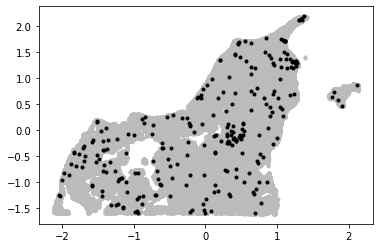

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
x_train = data.tensors['X'][train_idxs]
x_pool = data.tensors['X'][pool_idxs]
y_pool = data.tensors['y'][pool_idxs]
plt.plot(x_pool[:, 0].numpy(), x_pool[:, 1].numpy(), '.', color='#BBBBBB')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), '.', color='k')
plt.show()

Next, we create a fully-connected NN model with NTK Parametrization using the function `create_tabular_model` and train it using `fit_model`. Both functions contain more optional arguments to modify hyperparameters like the width and number of layers, the learning rate, and so on. We refer to the respective implementations for more details.

Unlike typical PyTorch code, the two functions mentioned above work with NNs that are vectorized such that multiple ensemble members are trained separately. The number of ensemble members is given by the `n_models` parameter, which we set to $1$. In order to obtain a non-vectorized NN in the end, which is required for BMDAL, we call the function `get_single_model()`.

In [8]:
from train import fit_model
from models import create_tabular_model

n_models = 1
n_features = data.tensors['X'].shape[1]  # will be 2 in our case
vectorized_model = create_tabular_model(n_models=n_models, n_features=n_features)
fit_model(vectorized_model, data, n_models, train_idxs, valid_idxs)
model = vectorized_model.get_single_model(0)

................................................................................................................................................................................................................................................................


The model structure, printed below, contains some custom layer types. The `ParallelSequential` and `ParallelLayerWrapper` layers come from the vectorization, but for the purpose of BMDAL `ParallelSequential` could be replaced by `nn.Sequential` and `ParallelLayerWrapper` could be omitted. The class `bmdal.layer_features.LinearLayer` implements the abstract class `bmdal.layer_features.LayerGradientComputation` and is therefore automatically used for computing gradient features. Compared to `nn.Linear`, `LinearLayer` supports weight and bias factors $\sigma_w/\sqrt{d_l}$ and $\sigma_b$ from the Neural Tangent Parameterization as used in the paper.

In [9]:
print(model)

ParallelSequential(
  (layers): ModuleList(
    (0): LinearLayer()
    (1): ParallelLayerWrapper(
      (module): ReLU()
    )
    (2): LinearLayer()
    (3): ParallelLayerWrapper(
      (module): ReLU()
    )
    (4): LinearLayer()
  )
)


Now, we apply BMDAL to select a subset of elements from the pool set as in the example above.

In [10]:
from bmdal.feature_data import TensorFeatureData
from bmdal.algorithms import select_batch

X = TensorFeatureData(data.tensors['X'])
feature_data = {'train': X[train_idxs],
                'pool': X[pool_idxs]}
y_train = data.tensors['y'][train_idxs]
new_idxs, al_stats = select_batch(batch_size=128, models=[model], data=feature_data, y_train=y_train,
                                  selection_method='lcmd', sel_with_train=True, 
                                  base_kernel='grad', kernel_transforms=[('rp', [512])])

# move new_idxs from the pool set to the training set
# therefore, we first create a boolean array that is True at the indices in new_idxs and False elsewhere
logical_new_idxs = torch.zeros(pool_idxs.shape[-1], dtype=torch.bool)
logical_new_idxs[new_idxs] = True
# We now append the new indices to the training set
train_idxs = torch.cat([train_idxs, pool_idxs[logical_new_idxs]], dim=-1)
# and remove them from the pool set
pool_idxs = pool_idxs[~logical_new_idxs]

Added 256 train samples to selection


The `al_stats` object contains some information about the execution of BMDAL. Here, the time for building the features and running the selection was about 19 seconds on a CPU, which is not very much considering that the initial pool set contains 198,720 samples! The entry for `selection_status` may contain a warning message in case that the normal selection failed. Usually, the batch is filled up with random samples in this case. Here, we have no warning.

In [11]:
print(al_stats)

{'kernel_time': {'total': 6.66116532900196, 'process': 53.213278265999996}, 'selection_time': {'total': 12.25830632999714, 'process': 48.66809945300001}, 'selection_status': None}


Next, we plot the selected points:

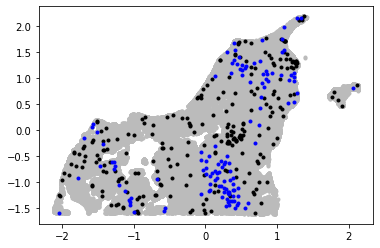

In [12]:
plt.plot(x_pool[:, 0].numpy(), x_pool[:, 1].numpy(), '.', color='#BBBBBB')
plt.plot(x_train[:, 0].numpy(), x_train[:, 1].numpy(), '.', color='k')
plt.plot(x_pool[new_idxs, 0].numpy(), x_pool[new_idxs, 1].numpy(), '.', color='b')
plt.show()

The selected points concentrate in some regions of the space. We can see that the labels (which correspond to the elevation of the land in this data set) vary more strongly in these regions:

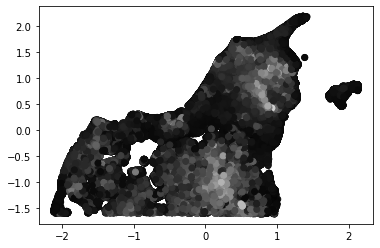

In [13]:
plt.scatter(x_pool[:, 0].numpy(), x_pool[:, 1].numpy(), c=y_pool[:, 0].numpy())
plt.gray()
plt.show()